# Making a Grid from an Emulator

The `stelevator` package provides a method for generating a regular grid of stellar models from the emulator. This is particularly useful for creating plots to see how grid parameters vary with initial conditions.

In this notebook we use the `MESASolarLikeEmulator` to create a grid and explore how changing the mixing length parameter and initial abundances changes stellar evolutionary tracks.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stelevator import MESASolarLikeEmulator

## Initialize the Grid

Firstly, let's initialize the emulator and look at a summary of its inputs and outputs.

In [2]:
emulator = MESASolarLikeEmulator()
print(emulator.summary)

MESASolarLikeEmulator

Inputs
------
f_evol: Fractional evolutionary phase.
mass (solMass): Stellar mass.
a_MLT: Mixing length parameter.
initial_Y: Initial stellar helium mass fraction.
initial_Z: Initial stellar heavy element mass fraction.

Outputs
-------
log_age (dex): Logarithm of stellar age in Gyr.
Teff (K): Stellar effective temperature.
radius (solRad): Stellar radius.
delta_nu (uHz): Asteroseismic large frequency separation.
surface_M_H (dex): Surface metallicity.


We can see that the initial abundances are paramterised by `"initial_Y"` and `"initial_Z"`. These are the initial mass fractions of helium and all heavier elements respectively, which obey

$$X + Y + Z = 1,$$

where $$X$$ is the hydrogen abundance.

## Grid Dimensions

Let's create the dimensions of our grid. We use `np.linspace` for the evolutionary stage and mass of the star, and a `list` for the remaining parameters. 

*Note: In future, the `emulator.summary` will outline the range for these parameters covered by the grid.*

In [34]:
dims = dict(
    f_evol=np.linspace(0.01, 2.0, 200),
    mass=np.linspace(0.8, 1.2, 5),
    a_MLT=[1.7, 2.0, 2.3],
    initial_Y=[0.24, 0.28, 0.32],
    initial_Z=[0.01, 0.02, 0.03],
)

## Creating the Grid

Creating the grid is a simple as calling `emulator.grid` and giving it the dimensions. It outputs a `pandas.DataFrame` object where the indices correspond to the input dimensions and the columns are outputs from the emulator.

In [35]:
grid = emulator.grid(**dims)
grid.head()

log_age         Teff    radius  \
f_evol mass a_MLT initial_Y initial_Z                                    
0.01   0.8  1.7   0.24      0.01      -0.660627  4888.856815  0.726576   
                            0.02      -0.510361  4395.564384  0.729746   
                            0.03      -0.407394  4145.659268  0.723226   
                  0.28      0.01      -0.787132  5154.590273  0.733256   
                            0.02      -0.632512  4655.806458  0.732921   

                                         delta_nu  surface_M_H  
f_evol mass a_MLT initial_Y initial_Z                           
0.01   0.8  1.7   0.24      0.01       196.260268    -0.132928  
                            0.02       195.463307     0.172506  
                            0.03       198.072610     0.353671  
                  0.28      0.01       193.010575    -0.109822  
                            0.02       193.651777     0.196745

## Plotting the Grid

To plot the grid, we will make a helper function. The function takes the `grid` and the name of the parameter we want to `vary`` in the plot.

We get the indices for the grid points to be plot. For example, if `vary="a_MLT"` then we want to fix `initial_Y` and `initial_Z` to make it easy to . In all cases we vary `f_evol` and `mass` since each track must have points along it (the evolutionary stage) and multiple tracks for each mass. Varying more than this makes the plot too crowded.

We make use of the `pandas.DataFrame.groupby` method to loop through stellar tracks and plot them individually.

In [61]:
def plot_grid(grid: pd.DataFrame, vary: str, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    # Get the indices for the grid points to be plot
    indices = ()
    for key in dims:
        if key in {"f_evol", "mass"} or key == vary:
            indices += (slice(None),)
        else:
            indices += (dims[key][0],)

    # Group by the mass and other varying parameter
    groups = grid.loc[indices, :].groupby(level=["mass", vary])

    # Plot each group
    for j, (index, group) in enumerate(groups):
        color = f"C{dims[vary].index(index[1])}"  # color by varying parameter
        label = f"{vary}={index[1]}" if j < len(dims[vary]) else None  # label only once
        ax.plot(group.Teff, group.delta_nu, color=color, label=label)

    ax.set_xlabel(r"$T_\mathrm{eff}$ (K)")
    ax.set_ylabel(r"$\Delta\nu \ (\mathrm{\mu Hz})$")
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.legend()
    return ax

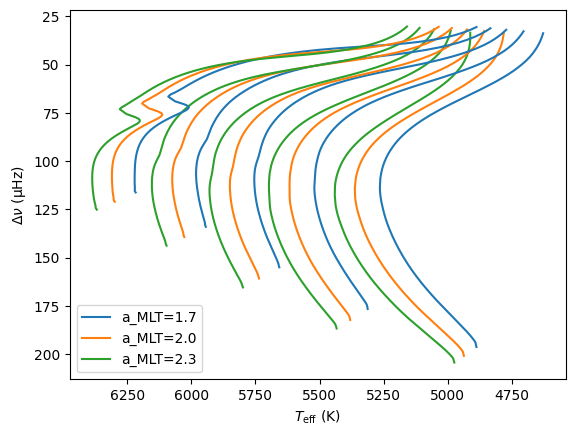

In [62]:
plot_grid(grid, "a_MLT");

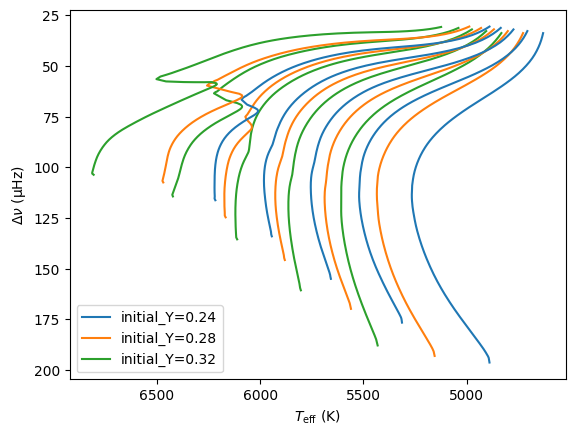

In [63]:
plot_grid(grid, "initial_Y");

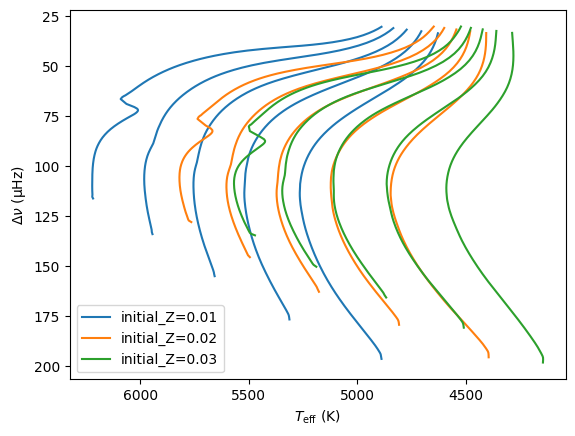

In [64]:
plot_grid(grid, "initial_Z");